In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="3"
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import copy
from random import randint
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cu102
Torchvision Version:  0.12.0+cu102


In [ ]:
from pytorch_metric_learning.losses import ArcFaceLoss

In [1]:
import wandb
wandb.login()

In [ ]:
# src: (Official Pytorch tutorials)
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

# it's just my custom division into validation and train
val_sub_dir_name = 'my_val'
train_sub_dir_name = 'my_train'

data_dir = "../CASIA-HWDB_Train"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 7330

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 150

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
!mkdir task2_resnet18_v2_checkpoints_run3

In [ ]:
def train_model(model, dataloaders, emb_loss, optimizer, emb_loss_optimizer, num_epochs=25):
    wandb.init()

    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_acc = 0.0
    for epoch in range(num_epochs):
        torch.save(model.state_dict(), f'task2_resnet18_v2_checkpoints_run3/epoch_{epoch}_acc_{(epoch_acc*100.0):.2f}.pth')
        torch.save(emb_loss.state_dict(), f'task2_resnet18_v2_checkpoints_run3/epoch_{epoch}_acc_{(epoch_acc*100.0):.2f}.emb_loss.pth')
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                emb_loss.train()
            else:
                model.eval()   # Set model to evaluate mode
                emb_loss.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                emb_loss_optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    embeddings = model(inputs)
                    
                    loss = emb_loss(embeddings=embeddings, labels=labels)
                    
                    with torch.no_grad():
                        logits = emb_loss.get_logits(embeddings=embeddings)
                        _, preds = torch.max(logits, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        emb_loss_optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                wandb.log({
                    f"{phase}_batch_loss": loss.item(),
                    f"{phase}_batch_accuracy": torch.sum(preds == labels.data).item() / len(preds),
                    f"{phase}_epoch": epoch,
                })

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


# def set_parameter_requires_grad(model, feature_extracting):
#     if feature_extracting:
#         for param in model.parameters():
#             param.requires_grad = False
            
def set_parameter_requires_grad(model, feature_extracting, unfreeze_from=None):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    if unfreeze_from is not None:
        assert isinstance(unfreeze_from, int)
        for ix, child in enumerate(model.children()):
            if ix > unfreeze_from:
                for param in child.parameters():
                    param.requires_grad = True
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract, unfreeze_from=4)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Identity()
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
arcface_loss = ArcFaceLoss(num_classes=num_classes, embedding_size=512)

# Print the model we just instantiated
print(model_ft)
print(arcface_loss)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Pad(100, 255),
        transforms.RandomRotation(15, fill=255),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Pad(100, 255),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {
    'train': 
        datasets.ImageFolder(
            os.path.join(data_dir, train_sub_dir_name)
            , data_transforms['train']
        ), 
    'val': 
        datasets.ImageFolder(
            os.path.join(data_dir, val_sub_dir_name)
            , data_transforms['val']
        ) 
}
dtset_val_not_transform = datasets.ImageFolder(os.path.join(data_dir, val_sub_dir_name))
dtset_train_not_transform = datasets.ImageFolder(os.path.join(data_dir, train_sub_dir_name))

# Create training and validation dataloaders
dataloaders_dict = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) 
    for x in ['train', 'val']
}

# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Initializing Datasets and Dataloaders...
cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


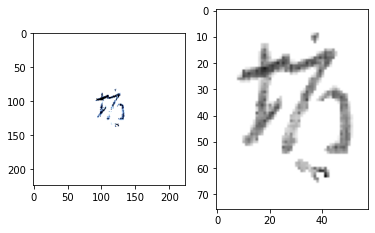

In [ ]:
# image_datasets['val'][0][0].shape
idx = randint(0, len(image_datasets['train']) - 1)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_datasets['train'][idx][0].permute(1, 2, 0))
axarr[1].imshow(dtset_train_not_transform[idx][0])
plt.show()

In [ ]:
device="cuda"
model_ft = model_ft.to(device)
arcface_loss = arcface_loss.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-3)
arcface_loss_optimizer = optim.Adam(arcface_loss.parameters(), lr=5e-4)

Params to learn:
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer3.1.bn2.bias
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 la

In [ ]:
# model_ft.load_state_dict(torch.load('task2_resnet18_v2_checkpoints_run2/epoch_1_acc_88.97.pth'), strict=False)
# arcface_loss.load_state_dict(torch.load("task2_resnet18_v2_checkpoints_run2/epoch_1_acc_88.97.emb_loss.pth"), strict=True)

<All keys matched successfully>

In [ ]:
model_ft.load_state_dict(torch.load('epoch_15_acc_95.39.pth'), strict=True)
arcface_loss.load_state_dict(torch.load("epoch_15_acc_95.39.emb_loss.pth"), strict=True)

<All keys matched successfully>

In [ ]:
model_ft = model_ft.to(device)
arcface_loss = arcface_loss.to(device)

In [2]:
# Setup the loss fxn
# criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, arcface_loss, optimizer_ft, arcface_loss_optimizer, num_epochs=num_epochs)

# P.S. this cell was restarted several times, so in total it had > 15 epochs

### Запускаем чтобы узнать результаты на тесте

In [ ]:

final_test_dataset = datasets.ImageFolder(
            '/home/nojusupov/Test/'
            , data_transforms['val']
) 

In [ ]:
final_test_dataloader = \
    torch.utils.data.DataLoader(final_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4) 

In [ ]:
res = []
idx_to_class = {idx:class_ for class_, idx in image_datasets['train'].class_to_idx.items()}

model_ft.eval()
arcface_loss.eval()

with torch.no_grad():
    for idx, (filename, _) in tqdm(list(enumerate(final_test_dataset.imgs))):
        im = final_test_dataset[idx][0]
        embeddings = model_ft(im.unsqueeze(0).to(device))
        logits = arcface_loss.get_logits(embeddings=embeddings)
        _, preds = torch.max(logits, 1)
        class_ = idx_to_class[preds.item()]
        res.append(
            filename.replace('/home/nojusupov/Test/,/', 'Test/UNKNOWN/') + ' ' + class_
        )

  0%|          | 0/776523 [00:00<?, ?it/s]

In [ ]:
res[-1]

'Test/UNKNOWN/99999.png 尹'

In [ ]:
with open('/home/nojusupov/course_ocr/task2/pred_arcface.txt', 'wt') as f:
    for el in tqdm(res):
        f.write(el + '\n')

  0%|          | 0/776523 [00:00<?, ?it/s]

In [ ]:
from pathlib import Path

def evaluate(gt_path, pred_path):
    gt = dict()
    with open(gt_path) as gt_f:
        for line in gt_f:
            name, cls = line.strip().split()
            gt[name] = cls
    
    n_good = 0
    n_all = len(gt)
    with open(pred_path) as pred_f:
        for line in pred_f:
            name, cls = line.strip().split()
            if cls == gt[name]:
                n_good += 1
    
    return n_good / n_all


def _run_evaluation():
    base = Path('/home/nojusupov/course_ocr/task2')
    gt_path = base / 'gt.txt'
    pred_path = base / 'pred_arcface.txt'
    score = evaluate(gt_path, pred_path)
    print('Accuracy = {:1.4f}'.format(score))

_run_evaluation()

Accuracy = 0.9338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


(6697, '队')

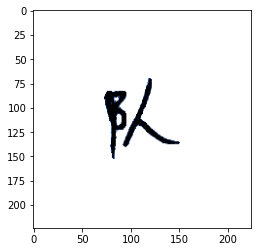

In [ ]:
idx = randint(0, len(final_test_dataset) - 1)
im = final_test_dataset[idx][0]
plt.imshow(im.permute(1,2,0))
print(im.shape)
embeddings = model_ft(im.unsqueeze(0).to(device))
logits = arcface_loss.get_logits(embeddings=embeddings)
_, preds = torch.max(logits, 1)
preds.item(), idx_to_class[preds.item()]